# **0. Preliminaries**

In [ ]:
pip install pandas openpyxl

In [ ]:
# Mounting Drive for loading .xlsx files and saving models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMPORTANT TO USE datasets for compatibility
!pip install datasets==3.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"       # Set to true to avoid API prompt during fine-tuning

In [ ]:
!pip uninstall transformers -y
!pip install --upgrade transformers

Found existing installation: transformers 4.52.2
Uninstalling transformers-4.52.2:
  Successfully uninstalled transformers-4.52.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 61.4 MB/s eta 0:00:00


# **1. Loading and Tokenization**

In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# REPRODUCIBILITY
SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# CHANGE THIS FOR PREVIOUS DATASET for V1 or V2
train_file = "/content/drive/MyDrive/200MODELS/MPREMASK_TRAIN_V2.xlsx"
dev_file = "/content/drive/MyDrive/200MODELS/MPREMASK_DEV_V2.xlsx"
test_file = "/content/drive/MyDrive/200MODELS/MPREMASK_TEST_V2.xlsx"

# Model name (SpanBERT)
MODEL_NAME = "SpanBERT/spanbert-base-cased"

# Function to load Excel data into a Hugging Face Dataset
def load_excel_data(train_file, dev_file, test_file):
    def process_file(file_path):
        df = pd.read_excel(file_path)
        return Dataset.from_pandas(df)

    datasets = DatasetDict({
        "train": process_file(train_file),
        "dev": process_file(dev_file),
        "test": process_file(test_file)
    })
    return datasets

datasets = load_excel_data(train_file, dev_file, test_file)

# FIXED label-to-ID mapping
label_to_id = {"no_relation": 0, "has_taxon": 1, "has_habitat": 2}

# Assign numeric labels to all splits (i.e no_relation = 0)
for split in datasets.keys():
    datasets[split] = datasets[split].map(lambda example: {"label": label_to_id[example["relation"]]})

# Tokenizer (SpanBERT = Wordpiece) + max seq length
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
max_seq_length = 128

# Tokenization function
def tokenize_data(batch):
    encodings = tokenizer(batch["chunk"], padding="max_length", truncation=True, max_length=max_seq_length)
    encodings["labels"] = batch["label"]  # Keep numeric label
    return encodings

# Apply tokenization to all splits
tokenized_datasets = datasets.map(tokenize_data, batched=True)

# Remove unnecessary columns after tokenization
columns_to_remove = ["chunk", "relation"]
tokenized_datasets = tokenized_datasets.remove_columns(columns_to_remove)

# Ensure consistency across multiple runs
tokenized_datasets.set_format("torch")

# Display tokenized sample for verification
print("\nSample tokenized dataset:")
print(tokenized_datasets["train"].to_pandas().head(5))  # Show first 5 rows

print("\n✅ Dataset tokenized and ready for training.")

Map:   0%|          | 0/4391 [00:00<?, ? examples/s]

Map:   0%|          | 0/699 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Map:   0%|          | 0/4391 [00:00<?, ? examples/s]

Map:   0%|          | 0/699 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]


Sample tokenized dataset:
   label                                          input_ids  \
0      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
1      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
2      1  [101, 2076, 10157, 119, 783, 185, 20473, 9717,...   
3      0  [101, 2853, 1104, 15003, 6360, 3614, 1475, 994...   
4      1  [101, 1292, 1530, 1132, 1802, 1303, 1394, 1443...   

                                      token_type_ids  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                      attention_mask  labels  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       0  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...       1  
3  [1

In [ ]:
# Remove unnecessary columns
columns_to_remove = ["token_type_ids", "labels"]  # Remove redundant columns
tokenized_datasets = tokenized_datasets.remove_columns(columns_to_remove)

# Reorder columns: Move 'label' to the rightmost position
def reorder_columns(example):
    return {
        "input_ids": example["input_ids"],
        "attention_mask": example["attention_mask"],
        "label": example["label"],  # Move 'label' to the last column
    }

#tokenized_datasets = tokenized_datasets.map(reorder_columns)

# Verify the cleaned dataset
print("\nDropped uneccesary columns:")
print(tokenized_datasets["train"].to_pandas().head(5))


Dropped uneccesary columns:
   label                                          input_ids  \
0      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
1      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
2      1  [101, 2076, 10157, 119, 783, 185, 20473, 9717,...   
3      0  [101, 2853, 1104, 15003, 6360, 3614, 1475, 994...   
4      1  [101, 1292, 1530, 1132, 1802, 1303, 1394, 1443...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  


In [ ]:
print(f"Random Seed: {SEED}")
print(f"PyTorch Random State: {torch.initial_seed()}")
print(f"Numpy Random State: {np.random.get_state()[1][0]}")
print(f"Random Library State: {random.getstate()[1][0]}")

Random Seed: 7
PyTorch Random State: 7
Numpy Random State: 7
Random Library State: 2147483648


# **2. Baseline Performance**

In [ ]:
from transformers import TrainingArguments, Trainer
import torch
from transformers import AutoModelForSequenceClassification

print(f"Random Seed: {SEED}")



def print_training_params(args, model):
    print("\n=== Training Parameters ===")
    print(f"Model: {model.name_or_path}")
    print(f"Output directory: {args.output_dir}")
    print(f"Learning rate: {args.learning_rate}")
    print(f"Per device train batch size: {args.per_device_train_batch_size}")
    print(f"Per device eval batch size: {args.per_device_eval_batch_size}")
    print(f"Num train epochs: {args.num_train_epochs}")
    print(f"Weight decay: {args.weight_decay}")
    print(f"Seed: {args.seed}")
    print(f"Logging steps: {args.logging_steps}")
    print(f"Evaluation strategy: {args.eval_strategy}")
    print(f"Save strategy: {args.save_strategy}")
    print("=========================\n")


print(tokenized_datasets["train"].to_pandas().head(5))


MODEL_SAVE_PATH = "/content/drive/MyDrive/200MODELS/SpanbertD2/SpanbertD2baseline"

# Define training arguments (DEFAULT settings, no manual overrides)
training_args = TrainingArguments(output_dir=MODEL_SAVE_PATH, seed=SEED)

num_labels = len(label_to_id)
print("Number of labels:", num_labels)

# Load SpanBERT model with correct number of labels
model = AutoModelForSequenceClassification.from_pretrained("SpanBERT/spanbert-base-cased", num_labels=num_labels)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
)

print_training_params(training_args, model)


# Train the model
trainer.train()

trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print("Model saved to: {MODEL_SAVE_PATH}")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Random Seed: 7
   label                                          input_ids  \
0      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
1      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
2      1  [101, 2076, 10157, 119, 783, 185, 20473, 9717,...   
3      0  [101, 2853, 1104, 15003, 6360, 3614, 1475, 994...   
4      1  [101, 1292, 1530, 1132, 1802, 1303, 1394, 1443...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training Parameters ===
Model: SpanBERT/spanbert-base-cased
Output directory: /content/drive/MyDrive/200MODELS/SpanbertD2/SpanbertD2baseline
Learning rate: 5e-05
Per device train batch size: 8
Per device eval batch size: 8
Num train epochs: 3.0
Weight decay: 0.0
Seed: 7
Logging steps: 500
Evaluation strategy: IntervalStrategy.NO
Save strategy: SaveStrategy.STEPS



Step,Training Loss
500,0.562600
1000,0.336600
1500,0.236000


Model saved to: {MODEL_SAVE_PATH}


### TEST SET EVAL


Sample TEST Set Predictions vs Actual Labels:
   Actual Label  Predicted Label
0             1                1
1             0                1
2             0                0
3             1                1
4             0                0
5             1                0
6             1                1
7             2                2
8             0                0
9             0                0

TEST Set Classification Report:
               precision    recall  f1-score   support

 no_relation       0.91      0.91      0.91       224
   has_taxon       0.83      0.85      0.84       101
 has_habitat       0.88      0.81      0.85        37

    accuracy                           0.88       362
   macro avg       0.87      0.86      0.86       362
weighted avg       0.88      0.88      0.88       362



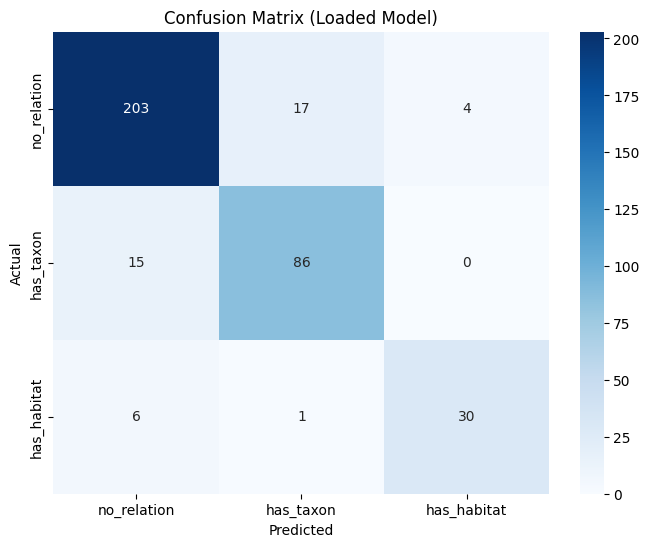

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

dev_results = trainer.predict(tokenized_datasets["test"])
dev_preds = dev_results.predictions.argmax(-1)
dev_labels = tokenized_datasets["test"]["label"]  # Use "label" column

# Display 10 samples of predictions vs. actual labels
comparison_df = pd.DataFrame({
    "Actual Label": dev_labels[:10].tolist(),
    "Predicted Label": dev_preds[:10].tolist()
})
print("\nSample TEST Set Predictions vs Actual Labels:")
print(comparison_df)

# Compute classification report
report = classification_report(dev_labels, dev_preds, target_names=label_to_id.keys())
print("\nTEST Set Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(dev_labels, dev_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Loaded Model)")
plt.show()

# **3. Hyperparameter Tuning and Experimentation**

## **3.1 Number of Epochs**

Random Seed: 7
   label                                          input_ids  \
0      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
1      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
2      1  [101, 2076, 10157, 119, 783, 185, 20473, 9717,...   
3      0  [101, 2853, 1104, 15003, 6360, 3614, 1475, 994...   
4      1  [101, 1292, 1530, 1132, 1802, 1303, 1394, 1443...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
Training with 2 epochs...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.313619,0.890335
2,0.452900,0.273550,0.915352


Epoch 2 completed - Training Loss: 0.4350, Validation Loss: 0.2735, F1: 0.9154
Training with 3 epochs...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.312227,0.887606
2,0.442800,0.242371,0.919400
3,0.442800,0.241196,0.928392


Epoch 3 completed - Training Loss: 0.3530, Validation Loss: 0.2412, F1: 0.9284
Training with 4 epochs...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.308057,0.891046
2,0.467800,0.257009,0.915736
3,0.467800,0.239278,0.931206
4,0.211800,0.238218,0.929964


Epoch 4 completed - Training Loss: 0.3238, Validation Loss: 0.2382, F1: 0.9300
Training with 5 epochs...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.308223,0.900038
2,0.474300,0.246907,0.920477
3,0.474300,0.265822,0.921755
4,0.226300,0.238700,0.932405
5,0.226300,0.247660,0.928255


Epoch 5 completed - Training Loss: 0.2943, Validation Loss: 0.2477, F1: 0.9283
Training with 6 epochs...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.332127,0.888252
2,0.460100,0.238168,0.921734
3,0.460100,0.241166,0.933915
4,0.216700,0.236517,0.936891
5,0.216700,0.269170,0.931662
6,0.139500,0.265402,0.937118


Epoch 6 completed - Training Loss: 0.2570, Validation Loss: 0.2654, F1: 0.9371


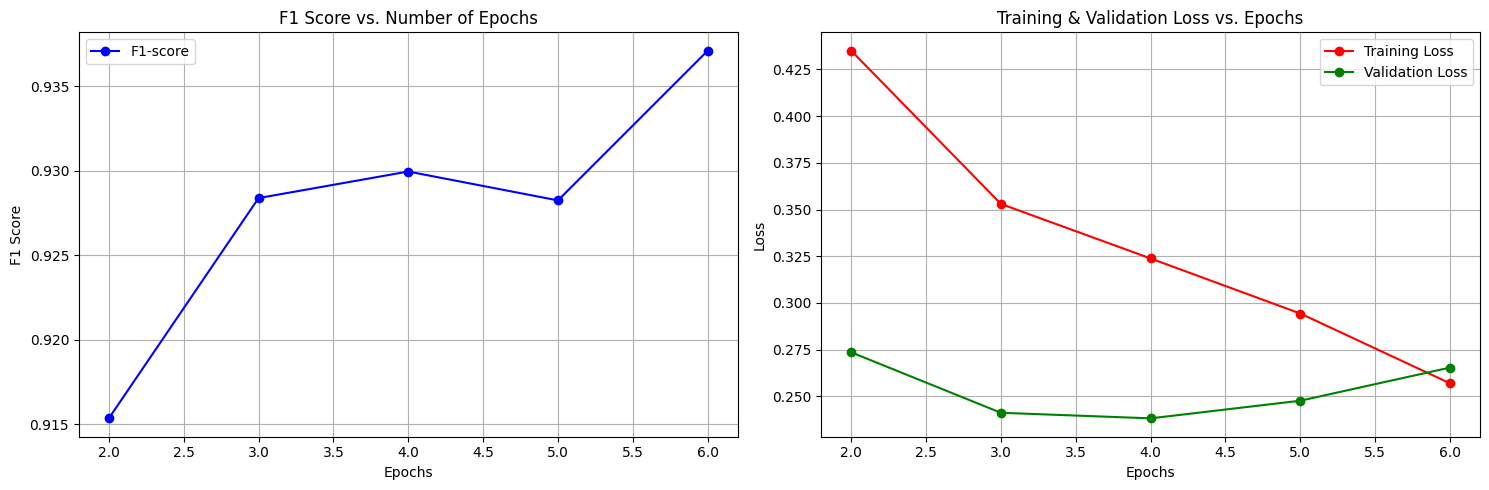


Final Metrics:
Epoch 2: F1=0.9154, Train Loss=0.4350, Val Loss=0.2735
Epoch 3: F1=0.9284, Train Loss=0.3530, Val Loss=0.2412
Epoch 4: F1=0.9300, Train Loss=0.3238, Val Loss=0.2382
Epoch 5: F1=0.9283, Train Loss=0.2943, Val Loss=0.2477
Epoch 6: F1=0.9371, Train Loss=0.2570, Val Loss=0.2654


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support

print(f"Random Seed: {SEED}")
print(tokenized_datasets["train"].to_pandas().head(5))
MODEL_SAVE_PATH = "/content/drive/MyDrive/200MODELS/spanbertEPOCH"

# Initialize lists to store metrics
epochs_range = list(range(2, 7))
f1_scores = []
train_losses = []  # Store training loss for each epoch run
eval_losses = []   # Store validation loss for each epoch run

# Loop through different epoch values and train the model
for epoch in epochs_range:
    print(f"Training with {epoch} epochs...\n")

    #spanbert_epoch_DIR = f"{MODEL_SAVE_PATH}/spanbert-epoch{epoch}"

    num_labels = len(label_to_id)
    print("Number of labels:", num_labels)

    # Load vanilla SpanBERT model with correct number of labels
    model = AutoModelForSequenceClassification.from_pretrained("SpanBERT/spanbert-base-cased", num_labels=num_labels)

    # Define training arguments with current epoch count
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epoch,  # Varying epochs
        weight_decay=0.01,
        logging_dir="./logs",
        seed=SEED,
        report_to="none"  # Disables external logging to keep console clean
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["dev"],
        compute_metrics=lambda pred: {
            "f1": precision_recall_fscore_support(
                pred.label_ids, pred.predictions.argmax(-1), average="macro"
            )[2]  # Extract F1-score
        }
    )

    # Train the model and capture training loss
    train_result = trainer.train()
    train_losses.append(train_result.training_loss)  # Store final training loss

    # Save model and tokenizer
    #trainer.save_model(spanbert_epoch_DIR)
    #tokenizer.save_pretrained(spanbert_epoch_DIR)

    # Evaluate on dev set and store metrics
    eval_results = trainer.evaluate()
    f1_scores.append(eval_results["eval_f1"])  # Store F1-score
    eval_losses.append(eval_results["eval_loss"])  # Store validation loss

    print(f"Epoch {epoch} completed - Training Loss: {train_result.training_loss:.4f}, Validation Loss: {eval_results['eval_loss']:.4f}, F1: {eval_results['eval_f1']:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 5))

# Plot 1: F1 Scores
plt.subplot(1, 2, 1)
plt.plot(epochs_range, f1_scores, marker="o", linestyle="-", color="b", label="F1-score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Number of Epochs")
plt.legend()
plt.grid(True)

# Plot 2: Loss Curves
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, marker="o", linestyle="-", color="r", label="Training Loss")
plt.plot(epochs_range, eval_losses, marker="o", linestyle="-", color="g", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs. Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics:")
for epoch, f1, train_loss, eval_loss in zip(epochs_range, f1_scores, train_losses, eval_losses):
    print(f"Epoch {epoch}: F1={f1:.4f}, Train Loss={train_loss:.4f}, Val Loss={eval_loss:.4f}")

In [ ]:
print(f"Random Seed: {SEED}")
print(f"PyTorch Random State: {torch.initial_seed()}")
print(f"Numpy Random State: {np.random.get_state()[1][0]}")
print(f"Random Library State: {random.getstate()[1][0]}")

Random Seed: 7
PyTorch Random State: 7
Numpy Random State: 7
Random Library State: 2147483648


**Epoch = 6 seems to be a good choice from its low computational cost and overfitting prevention**

## **3.2 Learning Rate**

Random Seed: 7
   label                                          input_ids  \
0      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
1      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
2      1  [101, 2076, 10157, 119, 783, 185, 20473, 9717,...   
3      0  [101, 2853, 1104, 15003, 6360, 3614, 1475, 994...   
4      1  [101, 1292, 1530, 1132, 1802, 1303, 1394, 1443...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
Training with learning rate 5e-06...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.689130,0.751653
2,0.772500,0.455578,0.866617
3,0.772500,0.376641,0.890410
4,0.434200,0.358967,0.896366
5,0.434200,0.353472,0.892186


Learning Rate 5e-06 completed - Training Loss: 0.5390, Validation Loss: 0.3535, F1: 0.8922
Training with learning rate 1e-05...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.455078,0.868808
2,0.610100,0.323437,0.894194
3,0.610100,0.292236,0.912032
4,0.315800,0.280880,0.912702
5,0.315800,0.264774,0.918380


Learning Rate 1e-05 completed - Training Loss: 0.4075, Validation Loss: 0.2648, F1: 0.9184
Training with learning rate 2e-05...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.335951,0.889844
2,0.494700,0.259503,0.922320
3,0.494700,0.296239,0.903767
4,0.238300,0.243618,0.924439
5,0.238300,0.243487,0.928528


Learning Rate 2e-05 completed - Training Loss: 0.3131, Validation Loss: 0.2435, F1: 0.9285
Training with learning rate 3e-05...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.310362,0.889402
2,0.455700,0.255048,0.912225
3,0.455700,0.243003,0.931367
4,0.209200,0.251275,0.921550
5,0.209200,0.244089,0.938818


Learning Rate 3e-05 completed - Training Loss: 0.2802, Validation Loss: 0.2441, F1: 0.9388
Training with learning rate 5e-05...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.310076,0.895032
2,0.459800,0.284185,0.895703
3,0.459800,0.250255,0.931047
4,0.212700,0.266654,0.937049
5,0.212700,0.287703,0.923462


Learning Rate 5e-05 completed - Training Loss: 0.2812, Validation Loss: 0.2877, F1: 0.9235


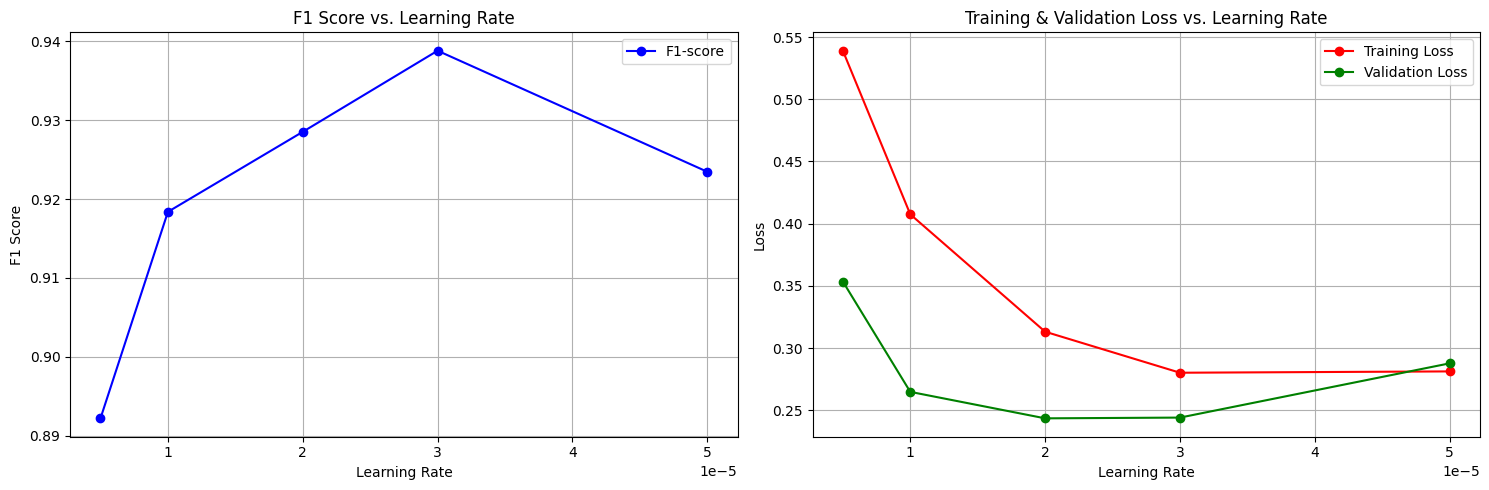


Final Metrics:
Learning Rate 5e-06: F1=0.8922, Train Loss=0.5390, Val Loss=0.3535
Learning Rate 1e-05: F1=0.9184, Train Loss=0.4075, Val Loss=0.2648
Learning Rate 2e-05: F1=0.9285, Train Loss=0.3131, Val Loss=0.2435
Learning Rate 3e-05: F1=0.9388, Train Loss=0.2802, Val Loss=0.2441
Learning Rate 5e-05: F1=0.9235, Train Loss=0.2812, Val Loss=0.2877


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support

print(f"Random Seed: {SEED}")
print(tokenized_datasets["train"].to_pandas().head(5))
MODEL_SAVE_PATH = "/content/drive/MyDrive/200MODELS/spanbertLR"

# Initialize lists to store metrics
lr_list = [5e-6, 1e-5, 2e-5, 3e-5, 5e-5]
f1_scores = []
train_losses = []
eval_losses = []

# Loop through different epoch values and train the model
for lr in lr_list:
    print(f"Training with learning rate {lr}...\n")

    # spanbert_epoch_DIR = f"{MODEL_SAVE_PATH}/spanbert-epoch{epoch}"

    num_labels = len(label_to_id)
    print("Number of labels:", num_labels)

    # Load vanilla SpanBERT model with correct number of labels
    model = AutoModelForSequenceClassification.from_pretrained("SpanBERT/spanbert-base-cased", num_labels=num_labels)

    # Define training arguments with current epoch count
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,       # Varying lr
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir="./logs",
        seed=SEED,
        report_to="none"
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["dev"],
        compute_metrics=lambda pred: {
            "f1": precision_recall_fscore_support(
                pred.label_ids, pred.predictions.argmax(-1), average="macro"
            )[2]  # Extract F1-score
        }
    )

    # Train the model and capture training loss
    train_result = trainer.train()
    train_losses.append(train_result.training_loss)  # Store final training loss

    # Save model and tokenizer
    # trainer.save_model(spanbert_epoch_DIR)
    # tokenizer.save_pretrained(spanbert_epoch_DIR)

    # Evaluate on dev set and store metrics
    eval_results = trainer.evaluate()
    f1_scores.append(eval_results["eval_f1"])  # Store F1-score
    eval_losses.append(eval_results["eval_loss"])  # Store validation loss

    print(f"Learning Rate {lr} completed - Training Loss: {train_result.training_loss:.4f}, Validation Loss: {eval_results['eval_loss']:.4f}, F1: {eval_results['eval_f1']:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 5))

# Plot 1: F1 Scores
plt.subplot(1, 2, 1)
plt.plot(lr_list, f1_scores, marker="o", linestyle="-", color="b", label="F1-score")
plt.xlabel("Learning Rate")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Learning Rate")
plt.legend()
plt.grid(True)

# Plot 2: Loss Curves
plt.subplot(1, 2, 2)
plt.plot(lr_list, train_losses, marker="o", linestyle="-", color="r", label="Training Loss")
plt.plot(lr_list, eval_losses, marker="o", linestyle="-", color="g", label="Validation Loss")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs. Learning Rate")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics:")
for lr, f1, train_loss, eval_loss in zip(lr_list, f1_scores, train_losses, eval_losses):
    print(f"Learning Rate {lr}: F1={f1:.4f}, Train Loss={train_loss:.4f}, Val Loss={eval_loss:.4f}")

In [ ]:
print(f"Random Seed: {SEED}")
print(f"PyTorch Random State: {torch.initial_seed()}")
print(f"Numpy Random State: {np.random.get_state()[1][0]}")
print(f"Random Library State: {random.getstate()[1][0]}")

Random Seed: 7
PyTorch Random State: 7
Numpy Random State: 7
Random Library State: 2147483648


**Learning Rate = 5e-05 exhibited good performance**

## **3.3 Batch Size**

Random Seed: 7
   label                                          input_ids  \
0      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
1      0  [101, 1952, 125, 119, 1598, 119, 1530, 27629, ...   
2      1  [101, 2076, 10157, 119, 783, 185, 20473, 9717,...   
3      0  [101, 2853, 1104, 15003, 6360, 3614, 1475, 994...   
4      1  [101, 1292, 1530, 1132, 1802, 1303, 1394, 1443...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
Training with batch size: 16...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.310362,0.889402
2,0.455700,0.255048,0.912225
3,0.455700,0.243003,0.931367
4,0.209200,0.251275,0.921550
5,0.209200,0.244089,0.938818


Batch 16 completed - Train Loss: 0.2802, Val Loss: 0.2441, F1: 0.9388
Training with batch size: 24...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.338734,0.880968
2,No log,0.245480,0.923935
3,0.405000,0.215394,0.935744
4,0.405000,0.246337,0.927061
5,0.405000,0.230468,0.940563


Batch 24 completed - Train Loss: 0.2958, Val Loss: 0.2305, F1: 0.9406
Training with batch size: 32...

Number of labels: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.466614,0.805041
2,No log,0.275998,0.904484
3,No log,0.253785,0.911241
4,0.379600,0.228946,0.927175
5,0.379600,0.230066,0.934730


Batch 32 completed - Train Loss: 0.3242, Val Loss: 0.2301, F1: 0.9347


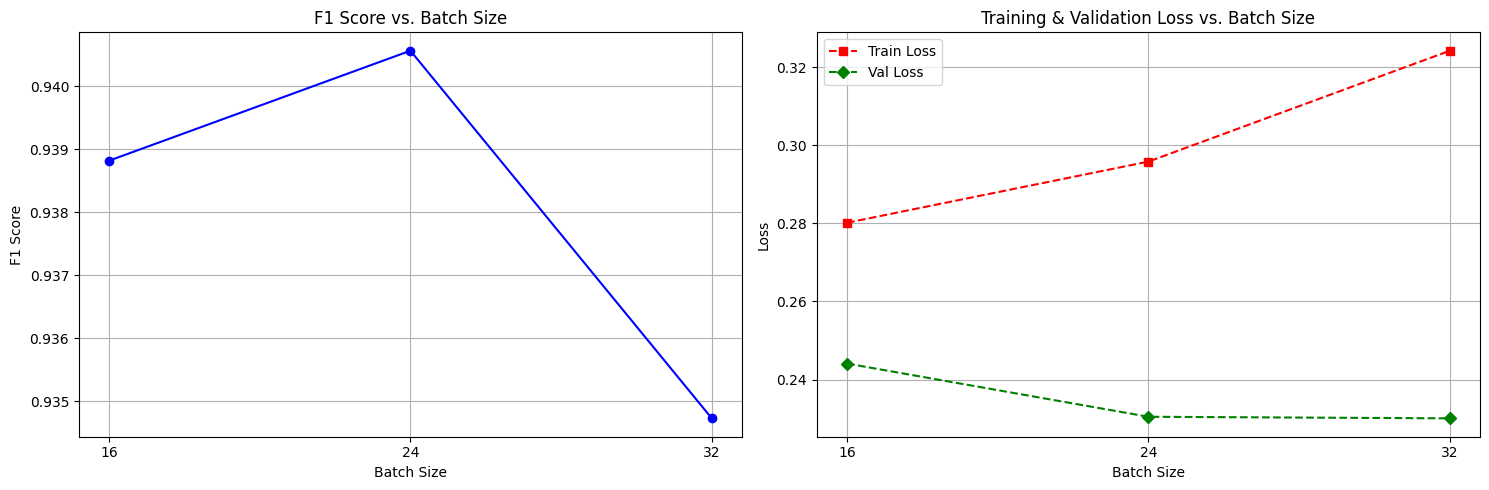


Batch Size Comparison:
Batch    F1 Score   Train Loss   Val Loss  
16       0.9388 0.2802 0.2441
24       0.9406 0.2958 0.2305
32       0.9347 0.3242 0.2301


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification

print(f"Random Seed: {SEED}")
print(tokenized_datasets["train"].to_pandas().head(5))
MODEL_SAVE_PATH = "/content/drive/MyDrive/200MODELS/spanbertBatch"

# Initialize lists to store metrics
batch_sizes = [16, 24, 32]  # Different batch sizes to test
f1_scores = []
train_losses = []
eval_losses = []

# Loop through different batch sizes
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}...\n")

    #spanbert_batch_DIR = f"{MODEL_SAVE_PATH}/spanbert-batch{batch_size}"

    num_labels = len(label_to_id)
    print("Number of labels:", num_labels)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained("SpanBERT/spanbert-base-cased", num_labels=num_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,  # Fixed learning rate
        per_device_train_batch_size=batch_size,  # Varying batch size
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,  # Fixed number of epochs
        weight_decay=0.01,
        logging_dir="./logs",
        seed=SEED,
        report_to="none"
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["dev"],
        compute_metrics=lambda pred: {
            "f1": precision_recall_fscore_support(
                pred.label_ids, pred.predictions.argmax(-1), average="macro"
            )[2]
        }
    )

    # Train and capture losses
    train_result = trainer.train()
    train_losses.append(train_result.training_loss)

    # Save model
    #trainer.save_model(spanbert_batch_DIR)
    #tokenizer.save_pretrained(spanbert_batch_DIR)

    # Evaluate
    eval_results = trainer.evaluate()
    f1_scores.append(eval_results["eval_f1"])
    eval_losses.append(eval_results["eval_loss"])

    print(f"Batch {batch_size} completed - Train Loss: {train_result.training_loss:.4f}, Val Loss: {eval_results['eval_loss']:.4f}, F1: {eval_results['eval_f1']:.4f}")

# Create separate plots
plt.figure(figsize=(15, 5))

# Plot 1: F1 Scores
plt.subplot(1, 2, 1)
plt.plot(batch_sizes, f1_scores, marker="o", linestyle="-", color="b")
plt.xlabel("Batch Size")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Batch Size")
plt.xticks(batch_sizes)
plt.grid(True)

# Plot 2: Loss Curves
plt.subplot(1, 2, 2)
plt.plot(batch_sizes, train_losses, marker="s", linestyle="--", color="r", label="Train Loss")
plt.plot(batch_sizes, eval_losses, marker="D", linestyle="--", color="g", label="Val Loss")
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs. Batch Size")
plt.xticks(batch_sizes)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print metrics table
print("\nBatch Size Comparison:")
print(f"{'Batch':<8} {'F1 Score':<10} {'Train Loss':<12} {'Val Loss':<10}")
for bs, f1, t_loss, v_loss in zip(batch_sizes, f1_scores, train_losses, eval_losses):
    print(f"{bs:<8} {f1:.4f} {t_loss:.4f} {v_loss:.4f}")

In [ ]:
print(f"Random Seed: {SEED}")
print(f"PyTorch Random State: {torch.initial_seed()}")
print(f"Numpy Random State: {np.random.get_state()[1][0]}")
print(f"Random Library State: {random.getstate()[1][0]}")

Random Seed: 7
PyTorch Random State: 7
Numpy Random State: 7
Random Library State: 2147483648


**Batch Size = 32 looks like a good choice**

# **4. Final Model Testing and Performance Evaluation**

Epochs = 5 \\
Learning rate = 3e-05 \\
Batch size  = 16 \\



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Random Seed: 7


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.453500,0.338734
2,0.310200,0.245480
3,0.232300,0.215394
4,0.217300,0.246337
5,0.127000,0.230468


Model saved to: /content/drive/MyDrive/200MODELS/SpanbertD2/SpanbertD2final



Sample TEST Set Predictions vs Actual TEST SET Labels:
   Actual Label  Predicted Label
0             1                1
1             0                1
2             0                0
3             1                1
4             0                0
5             1                0
6             1                1
7             2                2
8             0                0
9             0                0

TEST Set Classification Report:
               precision    recall  f1-score   support

 no_relation       0.92      0.88      0.90       224
   has_taxon       0.80      0.86      0.83       101
 has_habitat       0.83      0.92      0.87        37

    accuracy                           0.88       362
   macro avg       0.85      0.89      0.87       362
weighted avg       0.88      0.88      0.88       362



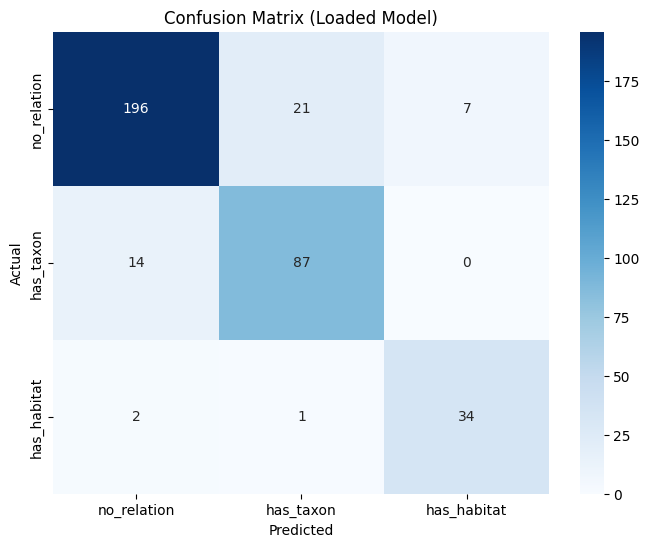

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

print(f"Random Seed: {SEED}")

#MODEL_SAVE_PATH = "/content/drive/MyDrive/200MODELS/SpanbertDset1"
MODEL_SAVE_PATH = "/content/drive/MyDrive/200MODELS/SpanbertD2/SpanbertD2final"

training_args = TrainingArguments(
    output_dir=MODEL_SAVE_PATH,
    seed=SEED,
    num_train_epochs=5,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=24,
    learning_rate=3e-5,
    weight_decay=0.01,
    eval_strategy="epoch",         # MATCHES save_strategy
    save_strategy="epoch",               # MATCHES evaluation_strategy
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",   # Optional but recommended
    save_total_limit=1                   # Optional: limit saved checkpoints
)

# Load SpanBERT model
num_labels = len(label_to_id)
model = AutoModelForSequenceClassification.from_pretrained("SpanBERT/spanbert-base-cased", num_labels=num_labels)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
)

# Train
trainer.train()

# Save model and tokenizer
trainer.save_model(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

print(f"Model saved to: {MODEL_SAVE_PATH}")

# Make predictions on the TEST set
dev_results = trainer.predict(tokenized_datasets["test"])
dev_preds = dev_results.predictions.argmax(-1)
dev_labels = tokenized_datasets["test"]["label"]  # Use "label" column

# Display 10 samples of predictions vs. actual labels
comparison_df = pd.DataFrame({
    "Actual Label": dev_labels[:10].tolist(),
    "Predicted Label": dev_preds[:10].tolist()
})
print("\nSample TEST Set Predictions vs Actual TEST SET Labels:")
print(comparison_df)

# Compute classification report
report = classification_report(dev_labels, dev_preds, target_names=label_to_id.keys())
print("\nTEST Set Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(dev_labels, dev_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Loaded Model)")
plt.show()

In [ ]:
print(f"Random Seed: {SEED}")
print(f"PyTorch Random State: {torch.initial_seed()}")
print(f"Numpy Random State: {np.random.get_state()[1][0]}")
print(f"Random Library State: {random.getstate()[1][0]}")

Random Seed: 7
PyTorch Random State: 7
Numpy Random State: 7
Random Library State: 2147483648


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


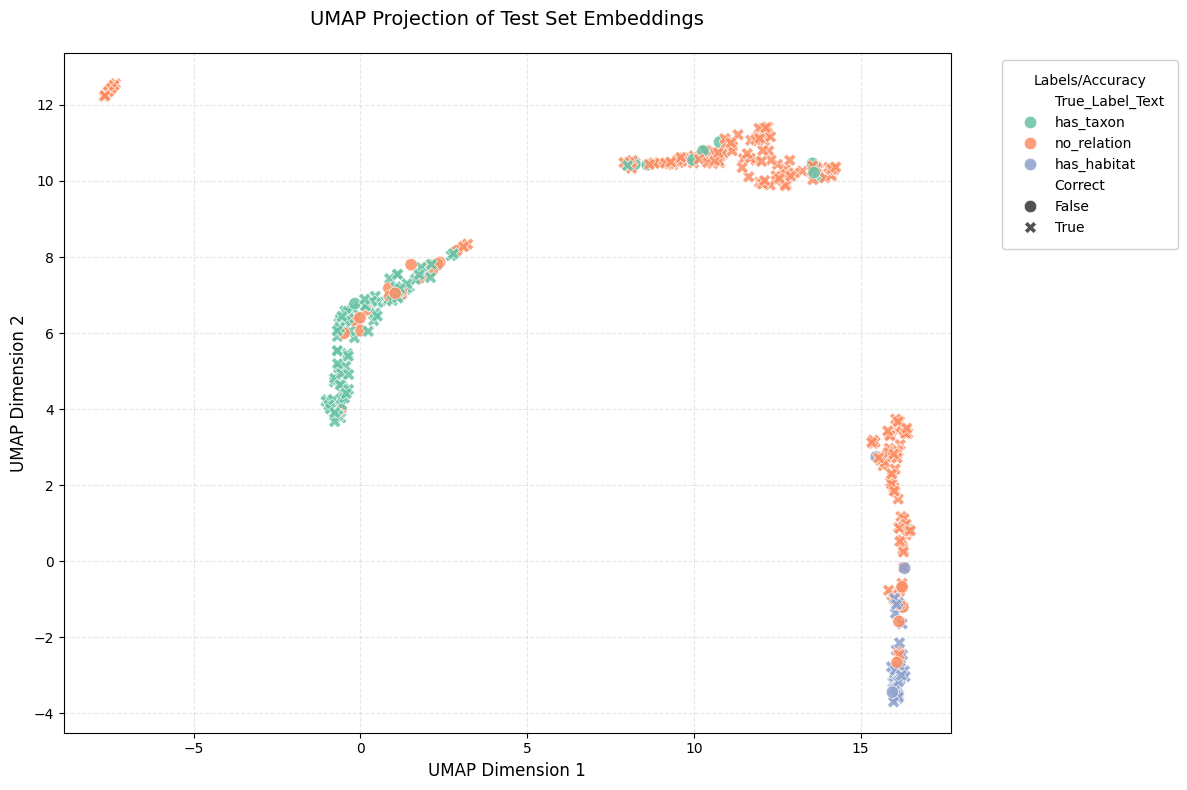

Excel saved to: /content/drive/MyDrive/200MODELS/SPANBERT_UMAP_analysis_with_text.xlsx;


In [ ]:
import pandas as pd
import umap
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# 1. Load data and model
raw_test_data = datasets["test"]
model_path = "/content/drive/MyDrive/200MODELS/SpanbertD2/SpanbertD2final"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.eval()

# 2. Get predictions and embeddings
trainer = Trainer(model=model)
test_results = trainer.predict(tokenized_datasets["test"])
pred_logits = test_results.predictions
pred_ids = pred_logits.argmax(-1)
pred_label_names = [id_to_label[i] for i in pred_ids]

# 3. Extract CLS embeddings
cls_embeddings = []
with torch.no_grad():
    for text in raw_test_data["chunk"]:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        outputs = model(**inputs, output_hidden_states=True)
        cls_emb = outputs.hidden_states[-1][:, 0, :].squeeze().cpu().numpy()
        cls_embeddings.append(cls_emb)

# 4. UMAP reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=SEED)
reduced = reducer.fit_transform(cls_embeddings)

# 5. Create comprehensive DataFrame
df = pd.DataFrame({
    "Original_Text": raw_test_data["chunk"],
    "x": reduced[:, 0],
    "y": reduced[:, 1],
    "True_Label_Text": raw_test_data["relation"],
    "True_Label_ID": tokenized_datasets["test"]["label"],
    "Predicted_Label": pred_label_names,
    "Correct": [true == pred for true, pred in zip(raw_test_data["relation"], pred_label_names)],
    "Prediction_Confidence": [max(torch.softmax(torch.tensor(logits), dim=0)).item() for logits in pred_logits]
})

# 6. Save results
output_path = "/content/drive/MyDrive/200MODELS/SPANBERT_UMAP_analysis_with_text.xlsx"
df.to_excel(output_path, index=False)

# 7. Enhanced Visualization
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=df,
    x="x", y="y",
    hue="True_Label_Text",
    style="Correct",
    palette="Set2",
    alpha=0.85,
    s=80,
    edgecolor='w',
    linewidth=0.5
)

# Style enhancements
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)
plt.title("UMAP Projection of Test Set Embeddings", pad=20, fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)

# Legend customization
legend = plt.legend(
    title='Labels/Accuracy',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    framealpha=0.9,
    borderpad=1
)

# Save and show
plt.tight_layout()
plt.show()

print(f"""Excel saved to: {output_path};""")